In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.rc = {'figure.figsize': (10,6)}
%matplotlib inline

## Generate a 2D triangular mesh

This notebook shows how to mesh a 2D image:

1. Load and visualize a 2D data image
2. Generate a 2D triangle mesh
3. Visualize the mesh
4. Relabel the regions
5. Export the mesh to other formats

### Load and vizualize the data

This example uses generated sample data from `nanomesh.data`.

If you want to use your own data, any (2D) numpy array can be passed to into a [`Image`](https://nanomesh.readthedocs.io/en/latest/nanomesh.plane.html#nanomesh.plane.Plane) object. Data stored as `.npy` can be loaded using `Image.load()`.

<AxesSubplot:xlabel='x', ylabel='y'>

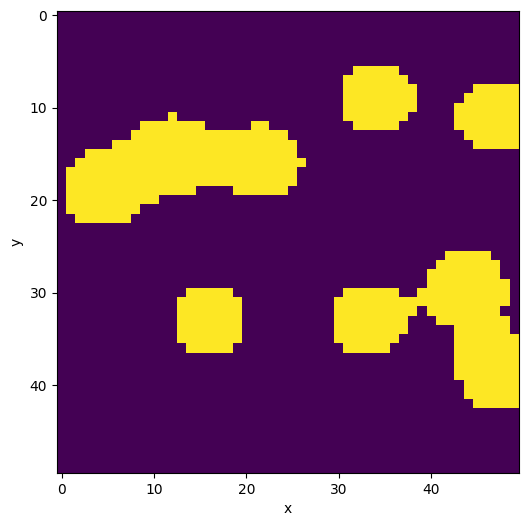

In [2]:
from nanomesh import Image
from nanomesh.data import binary_blobs2d

data = binary_blobs2d(seed=12345)

plane = Image(data)
plane.show()

### Generate mesh

Meshes are generated using the `Mesher2D` class. Meshing consists of two steps:

1. Contour finding (using the [`find_contours`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours) function
2. Triangulation (using the [`triangle`](https://rufat.be/triangle/) library)

Contour finding uses the [marching cubes algorithm](https://en.wikipedia.org/wiki/Marching_cubes) to wrap all the pores in a polygon. `max_edge_dist=5` splits up long edges in the contour, so that no two points are further than 5 pixels apart. `level` is directly passed to `find_contours` and specifies the level at which the contour is generated. In this case, we set it to the threshold value determined above.

<AxesSubplot:title={'center':'line mesh'}>

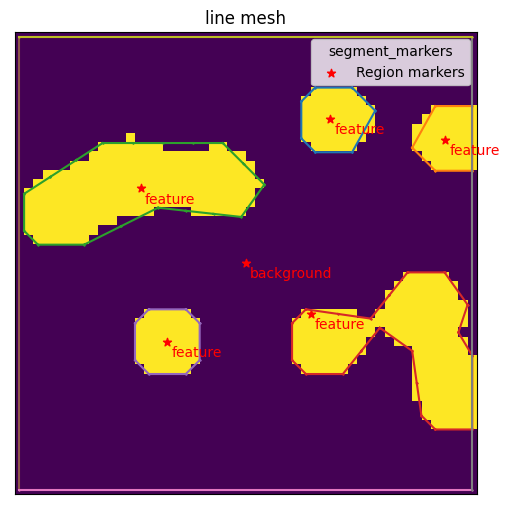

In [3]:
from nanomesh import Mesher2D

mesher = Mesher2D(plane)
mesher.generate_contour(max_edge_dist=3)

mesher.plot_contour()

The next step is to use the contours to initialize triangulation.

Triangulation options can be specified through the `opts` keyword argument. This example uses `q30` to generate a quality mesh with angles > 30°, and `a100` to set a maximum triangle size of 100 pixels. For more options, see [here](https://rufat.be/triangle/API.html#triangle.triangulate).

In [4]:
mesh = mesher.triangulate(opts='q30a100')

Triangulation returns a `MeshContainer` dataclass that can be used for various operations, for example comparing it with the original image:

<AxesSubplot:title={'center':'triangle mesh'}>

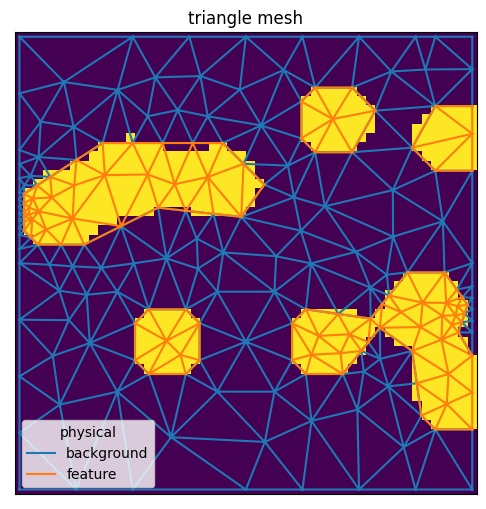

In [5]:
plane.compare_with_mesh(mesh)

### Region markers

By default, regions are split up in the *background* and *features*. Feature regions are grouped by the label 1.

In [6]:
mesher.contour.region_markers

RegionMarkerList(
    RegionMarker(label=2, point=(8.857142857142858, 33.642857142857146), name='feature', constraint=0),
    RegionMarker(label=2, point=(11.2, 46.1), name='feature', constraint=0),
    RegionMarker(label=2, point=(16.40277777777778, 13.152777777777779), name='feature', constraint=0),
    RegionMarker(label=2, point=(30.02357502501259, 31.509054204728493), name='feature', constraint=0),
    RegionMarker(label=2, point=(33.0, 16.0), name='feature', constraint=0),
    RegionMarker(label=1, point=(24.5, 24.5), name='background', constraint=0)
)

To label regions sequentially, set `group_regions=False`:

<AxesSubplot:title={'center':'line mesh'}>

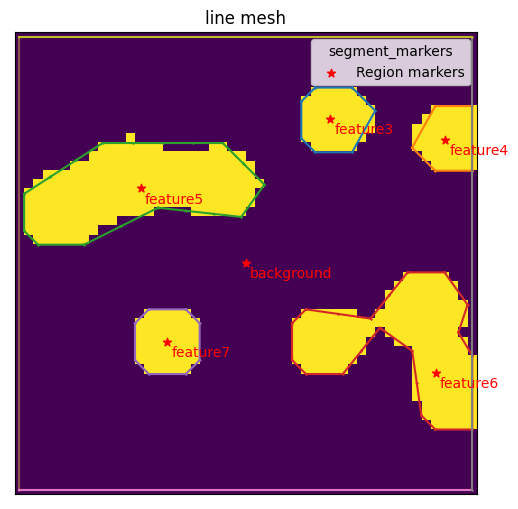

In [7]:
mesher = Mesher2D(plane)
mesher.generate_contour(max_edge_dist=3, group_regions=False)

mesher.plot_contour()

Notice that each feature has been given a unique name:

In [8]:
mesher.contour.region_markers

RegionMarkerList(
    RegionMarker(label=3, point=(8.857142857142858, 33.642857142857146), name='feature3', constraint=0),
    RegionMarker(label=4, point=(11.2, 46.1), name='feature4', constraint=0),
    RegionMarker(label=5, point=(16.40277777777778, 13.152777777777779), name='feature5', constraint=0),
    RegionMarker(label=6, point=(36.40467875597856, 45.03515883059761), name='feature6', constraint=0),
    RegionMarker(label=7, point=(33.0, 16.0), name='feature7', constraint=0),
    RegionMarker(label=1, point=(24.5, 24.5), name='background', constraint=0)
)

These labels will assigned to each triangle in the corresponding region after triangulation. These are stored in `mesh.cell_data` of the `MeshContainer`. This container stores a single set of points, and both the line segments (`LineMesh`) and triangles (`TriangleMesh`). To extract the triangle cells only, use `MeshContainer.get('triangle')`. this returns a class that is simpler to work with.

The cell below shows how to use this to access the cell data for the triangle cells in the mesh.

In [9]:
mesh = mesher.triangulate(opts='q30a100')
mesh.get('triangle').cell_data

{'physical': array([1., 1., 5., 1., 1., 5., 1., 5., 5., 1., 5., 1., 5., 1., 5., 1., 1.,
        5., 5., 1., 1., 1., 5., 5., 1., 5., 1., 5., 1., 3., 3., 1., 1., 3.,
        1., 1., 4., 1., 1., 1., 3., 1., 1., 1., 1., 5., 5., 1., 1., 1., 4.,
        1., 1., 4., 1., 3., 1., 1., 5., 1., 1., 1., 7., 1., 1., 1., 1., 6.,
        7., 1., 7., 1., 7., 1., 1., 1., 1., 7., 1., 1., 6., 1., 1., 6., 1.,
        7., 1., 6., 6., 1., 6., 6., 6., 6., 1., 6., 1., 6., 6., 1., 1., 1.,
        1., 1., 6., 1., 1., 6., 6., 6., 1., 1., 1., 1., 1., 6., 6., 1., 1.,
        1., 1., 1., 1., 1., 1., 5., 1., 1., 1., 5., 1., 1., 5., 1., 5., 1.,
        1., 1., 1., 1., 5., 1., 5., 5., 5., 1., 5., 5., 5., 5., 5., 6., 1.,
        1., 1., 5., 6., 1., 6., 1., 5., 5., 1., 1., 6., 1., 1., 6., 6., 6.,
        6., 6., 6., 1., 5., 5., 6., 6., 6., 6., 6., 6., 6., 1., 6., 1., 6.,
        1., 6., 1., 1., 6., 6., 1., 1., 1., 5., 1., 1., 6., 6., 5., 5., 3.,
        3., 1., 1., 1., 1., 1., 1., 1., 1., 7., 7., 1., 1., 6., 6., 1., 1.,


### Field data

Field data can be used to associate names with the values in the cell data. These are shown in the legend of mesh data (i.e. in the plots above). The field data is stored in the `.field_data` attribute. Because the data are somewhat difficult to use in this state, the properties `.field_to_number` and `.number_to_field` can be used to access the mapping per cell type.

In [10]:
mesh.number_to_field

mappingproxy({'triangle': mappingproxy({3: 'feature3',
                            4: 'feature4',
                            5: 'feature5',
                            6: 'feature6',
                            7: 'feature7',
                            1: 'background'})})

To update the values, you can update `.field_data` directory, or use `.set_field_data`. Note that field names are shared between cell types. For example, to relabel the cells data:



In [11]:
fields = {}
for k, v in mesh.number_to_field['triangle'].items():
    v = v.replace('background', 'Silicon')
    v = v.replace('feature', 'Pore')
    fields[k] = v

mesh.set_field_data('triangle', fields)
mesh.number_to_field

mappingproxy({'triangle': mappingproxy({3: 'Pore3',
                            4: 'Pore4',
                            5: 'Pore5',
                            6: 'Pore6',
                            7: 'Pore7',
                            1: 'Silicon'})})

Plotting the mesh now shows the fields in the legend. Note that the fields are also saved when exported to a format that supports them (e.g. *gmsh*).

(<AxesSubplot:title={'center':'line mesh'}>,
 <AxesSubplot:title={'center':'triangle mesh'}>)

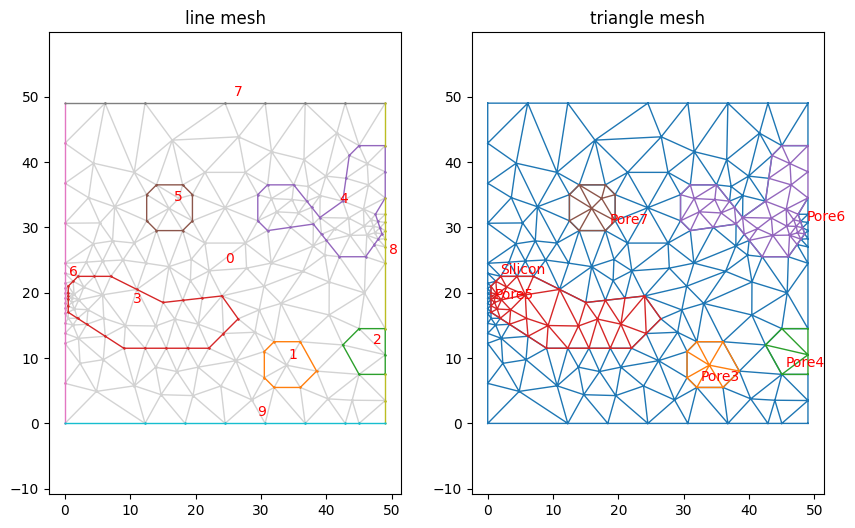

In [12]:
mesh.plot(lw=1, color_map={0: 'lightgray'}, legend='floating')

### Interoperability

The `MeshContainer` object can also be used to convert to various other library formats, such as:

- [`trimesh.Trimesh`](https://trimsh.org/trimesh.base.html#trimesh.base.Trimesh)
- [`pyvista.UnstructuredGrid`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)
- [`meshio.Mesh`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)

First, we must extract the triangle data:

In [13]:
triangle_mesh = mesh.get('triangle')

pv_mesh = triangle_mesh.to_pyvista_unstructured_grid()
trimesh_mesh = triangle_mesh.to_trimesh()
meshio_mesh = triangle_mesh.to_meshio()

To save the data, use the `.write` method. This is essentially a very thin wrapper around `meshio`, equivalent to `meshio.write(...)`.

In [14]:
mesh.write('out.msh', file_format='gmsh22', binary=False)

Warning: Appending zeros to replace the missing geometrical tag data.